# Book Recommendation System Using Clustering 



##  Setup and Imports

In [190]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings

In [191]:
# Define book category mapping with grouped categories
CATEGORY_MAPPING = {
    # Algebra
    '512': 'Math_Algebra',

    # Analysis / Calculus
    '515': 'Math_Analysis',

    # Probability & Statistics
    '519': 'Math_Statistics',

    # General Mathematics
    '510': 'Math_General',
    '511': 'Math_General',
    '518': 'Math_General',

    # Computer Science
    '004': 'Computer_Science',
    '005': 'Computer_Science',
    '006': 'Computer_Science',
    '681': 'Computer_Science',

    # Engineering
    '621': 'Engineering',

    # Everything else → OTHER
    '150': 'Other',   # Psychology
    '230': 'Other',   # Religion
    '350': 'Other',   # Public admin
    '380': 'Other',   # Commerce
    '570': 'Other',   # Life sciences
    '610': 'Other',   # Medicine
    '611': 'Other',
    '616': 'Other',
    '658': 'Other',
    '808': 'Other'
}

## Load and  Data

In [192]:
# Load borrowing data
df_borrowing = pd.read_excel('../data/Clean_Data/cleaned_borrowings.xlsx')

print("Dataset shape:", df_borrowing.shape)
print("\nFirst few rows:")
df_borrowing.head()

Dataset shape: (422, 10)

First few rows:


,Numéro,Cote,Titre,Type de document,N° lecteur,Nom,Prénom,Catégorie,Titre_clean,borrowing duration
0,1000,515 MON,Exercices corrigés d'analyse : 1ère année LMD,Livre,5817912,MAMECHE,FERIEL,1 ére ANNEE,EXERCICES CORRIGES D ANALYSE 1ERE ANNEE LMD,15
1,1005,510.BAL/1,Exercices d'algèbre et d'analyse : 154 exercic...,Livre,5754033,fourali,malak,1 ére ANNEE,EXERCICES D ALGEBRE ET D ANALYSE 154 EXERCICES...,17
2,1006,510.BAL/2,Exercices d'algèbre et d'analyse : 154 exercic...,Livre,5113394,SEHALI,MAYA,1 ére ANNEE,EXERCICES D ALGEBRE ET D ANALYSE 154 EXERCICES...,15
3,1007,510.BAL/3,Exercices d'algèbre et d'analyse : 154 exercic...,Livre,6092419,kheddaoui,thiziri,1 ére ANNEE,EXERCICES D ALGEBRE ET D ANALYSE 154 EXERCICES...,15
4,1009,518.107.BAY/1,Exercices et problèmes d'algorithmique : 144 é...,Livre,8354464,GACEB,RIHAM BAHIA,3 ème ANNEE,EXERCICES ET PROBLEMES D ALGORITHMIQUE 144 ENO...,7


In [193]:
# Basic statistics
print("Dataset Info:")
print(f"Total borrowings: {len(df_borrowing)}")
print(f"Unique borrowers: {df_borrowing['N° lecteur'].nunique()}")
print(f"Unique books: {df_borrowing['Cote'].nunique()}")

Dataset Info:
Total borrowings: 422
Unique borrowers: 271
Unique books: 398


## Feature Engineering: Extract Book Categories from Cote

Here we want to extract category code ( 512 , 504 ..) from the cote  (510.BAL/2 ..)

In [194]:
def extract_category_from_cote(cote):
    """Extract and map category code from Cote to grouped categories"""
    if pd.isna(cote):
        return 'Other'
    
    cote_str = str(cote).strip()
    
    # Extract first 3 digits and map to grouped category
    for key in CATEGORY_MAPPING.keys():
        if cote_str.startswith(key):
            return CATEGORY_MAPPING[key]
    
    return 'Other'

# Apply category extraction
df_borrowing['book_category'] = df_borrowing['Cote'].apply(extract_category_from_cote)

print("Grouped Category Distribution:")
print(df_borrowing['book_category'].value_counts())

Grouped Category Distribution:
book_category
Math_Algebra        146
Math_General         86
Computer_Science     77
Math_Analysis        47
Math_Statistics      35
Other                26
Engineering           5
Name: count, dtype: int64


## Create User Profile Table

we used the borrowing table , wich contains borrowings record , to create user profile wich contains the reader categories  , his borrowing statistics and preferences , so every borrower ( row)  is represented by his stats , pcts of each category  borrowed 

In [195]:
def create_user_profiles(df):
    """Create user profiles with grouped category percentages"""
    profiles = []
    
    # Get all unique grouped categories
    all_categories = df['book_category'].unique()
    
    for borrower_id in df['N° lecteur'].unique():
        user_data = df[df['N° lecteur'] == borrower_id]
        
        profile = {
            'N° lecteur': borrower_id,
            'Nom': user_data['Nom'].iloc[0],
            'Prénom': user_data['Prénom'].iloc[0],
            'Catégorie': user_data['Catégorie'].iloc[0],
            'total_borrowed': len(user_data),
            'avg_duration': user_data['borrowing duration'].mean(),
            'diversity_score': user_data['book_category'].nunique()
        }
        
        # Calculate percentage for each grouped category
        category_counts = user_data['book_category'].value_counts()
        total_books = len(user_data)
        
        for category in all_categories:
            count = category_counts.get(category, 0)
            profile[f'{category}_pct'] = (count / total_books) * 100
        
        profiles.append(profile)
    
    return pd.DataFrame(profiles)

# Create user profiles
df_profiles = create_user_profiles(df_borrowing)

print(f"\nCreated profiles for {len(df_profiles)} users")
print(f"Profile shape: {df_profiles.shape}")
print("\nSample profiles:")
df_profiles.head()


Created profiles for 271 users
Profile shape: (271, 14)

Sample profiles:


,N° lecteur,Nom,Prénom,Catégorie,total_borrowed,avg_duration,diversity_score,Math_Analysis_pct,Math_General_pct,Math_Algebra_pct,Other_pct,Computer_Science_pct,Math_Statistics_pct,Engineering_pct
0,5817912,MAMECHE,FERIEL,1 ére ANNEE,3,15.0,2,33.333333,0.000000,66.666667,0.0,0.000000,0.0,0.0
1,5754033,fourali,malak,1 ére ANNEE,3,17.0,3,0.000000,33.333333,33.333333,0.0,33.333333,0.0,0.0
2,5113394,SEHALI,MAYA,1 ére ANNEE,2,15.0,2,0.000000,50.000000,50.000000,0.0,0.000000,0.0,0.0
3,6092419,kheddaoui,thiziri,1 ére ANNEE,2,15.0,2,0.000000,50.000000,50.000000,0.0,0.000000,0.0,0.0
4,8354464,GACEB,RIHAM BAHIA,3 ème ANNEE,2,7.0,1,0.000000,100.000000,0.000000,0.0,0.000000,0.0,0.0


## Prepare Features for Clustering 

here we created a new table which we ar gonna use in the clustering which contains  : the stats ( total borrowed , avg_duration and diversity score of books ) , and the reader category in encoded format  , and the pct for each grouped category

In [196]:
# One-hot encode reader category
reader_categories_dummies = pd.get_dummies(df_profiles['Catégorie'], prefix='reader_cat')

print("Reader category one-hot encoded features:")
print(reader_categories_dummies.columns.tolist())

# Select percentage columns (grouped categories)
pct_columns = [col for col in df_profiles.columns if col.endswith('_pct')]

print(f"\nGrouped category percentage features: {len(pct_columns)}")
print(pct_columns)

# Behavioral features
behavioral_features = [
    'total_borrowed',
    'avg_duration',
    'diversity_score'
]

# Create feature matrix
X_behavioral = df_profiles[behavioral_features + pct_columns].copy()
X_full = pd.concat([X_behavioral, reader_categories_dummies], axis=1)

print(f"\nFinal feature matrix shape: {X_full.shape}")
print(f"Features: {X_full.shape[1]} total")
print(f"  - Behavioral: {len(behavioral_features)}")
print(f"  - Grouped category percentages: {len(pct_columns)}")
print(f"  - Reader category (one-hot): {reader_categories_dummies.shape[1]}")

Reader category one-hot encoded features:
['reader_cat_1 ére ANNEE', 'reader_cat_2 éme ANNEE', 'reader_cat_3 ème ANNEE', 'reader_cat_4 éme ANNEE', 'reader_cat_Employé', 'reader_cat_Enseignant']

Grouped category percentage features: 7
['Math_Analysis_pct', 'Math_General_pct', 'Math_Algebra_pct', 'Other_pct', 'Computer_Science_pct', 'Math_Statistics_pct', 'Engineering_pct']

Final feature matrix shape: (271, 16)
Features: 16 total
  - Behavioral: 3
  - Grouped category percentages: 7
  - Reader category (one-hot): 6


In [197]:
X_full.head()

,total_borrowed,avg_duration,diversity_score,Math_Analysis_pct,Math_General_pct,Math_Algebra_pct,Other_pct,Computer_Science_pct,Math_Statistics_pct,Engineering_pct,reader_cat_1 ére ANNEE,reader_cat_2 éme ANNEE,reader_cat_3 ème ANNEE,reader_cat_4 éme ANNEE,reader_cat_Employé,reader_cat_Enseignant
0,3,15.0,2,33.333333,0.000000,66.666667,0.0,0.000000,0.0,0.0,True,False,False,False,False,False
1,3,17.0,3,0.000000,33.333333,33.333333,0.0,33.333333,0.0,0.0,True,False,False,False,False,False
2,2,15.0,2,0.000000,50.000000,50.000000,0.0,0.000000,0.0,0.0,True,False,False,False,False,False
3,2,15.0,2,0.000000,50.000000,50.000000,0.0,0.000000,0.0,0.0,True,False,False,False,False,False
4,2,7.0,1,0.000000,100.000000,0.000000,0.0,0.000000,0.0,0.0,False,False,True,False,False,False


This is our final full table , before we do clustering we need to scale the values first

In [198]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

print("Features scaled successfully")
print(f"Scaled data shape: {X_scaled.shape}")

Features scaled successfully
Scaled data shape: (271, 16)


## PCA for User Profile Visualization

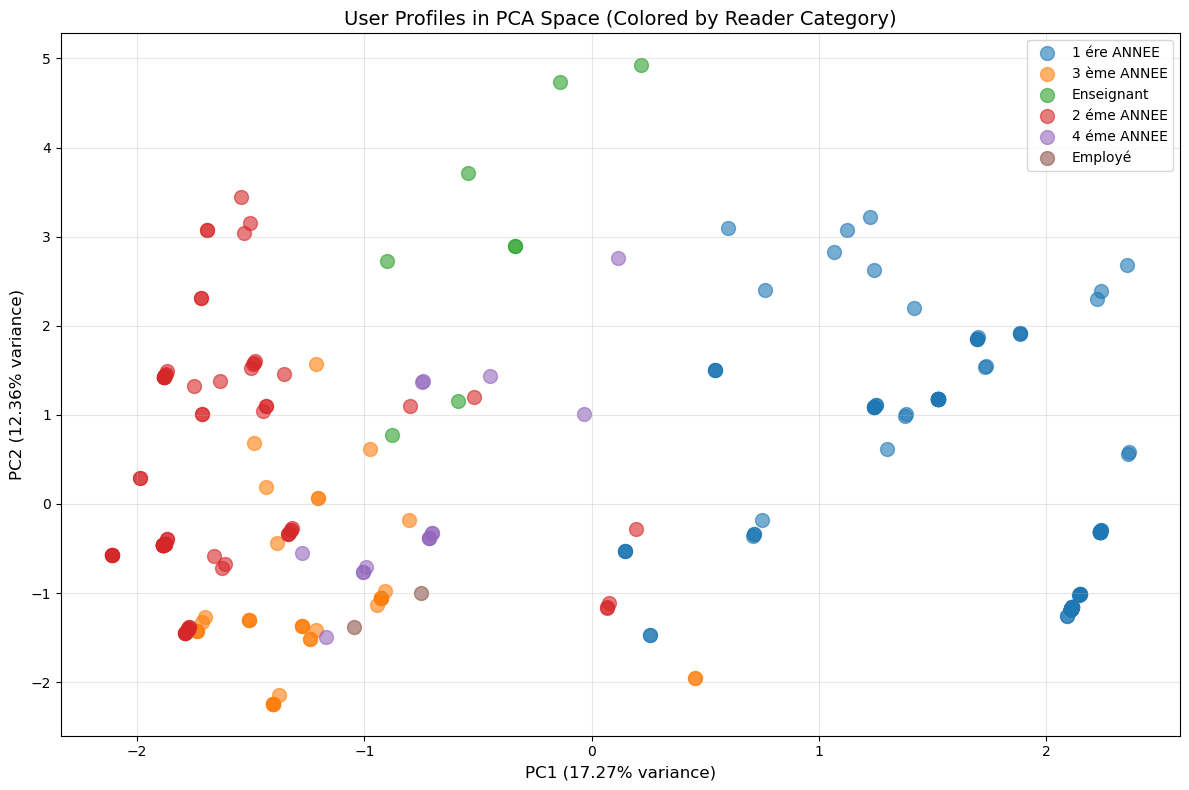

In [199]:
# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame with PCA results
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Reader_Category'] = df_profiles['Catégorie'].values

# Visualize user profiles in PCA space
plt.figure(figsize=(12, 8))
for category in df_pca['Reader_Category'].unique():
    mask = df_pca['Reader_Category'] == category
    plt.scatter(df_pca[mask]['PC1'], df_pca[mask]['PC2'], 
                label=category, alpha=0.6, s=100)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('User Profiles in PCA Space (Colored by Reader Category)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
# Clustering Approaches
---

## Approach 1: K-Means Clustering

### Step 1: Find Optimal Number of Clusters

c:\Users\DELL\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMe

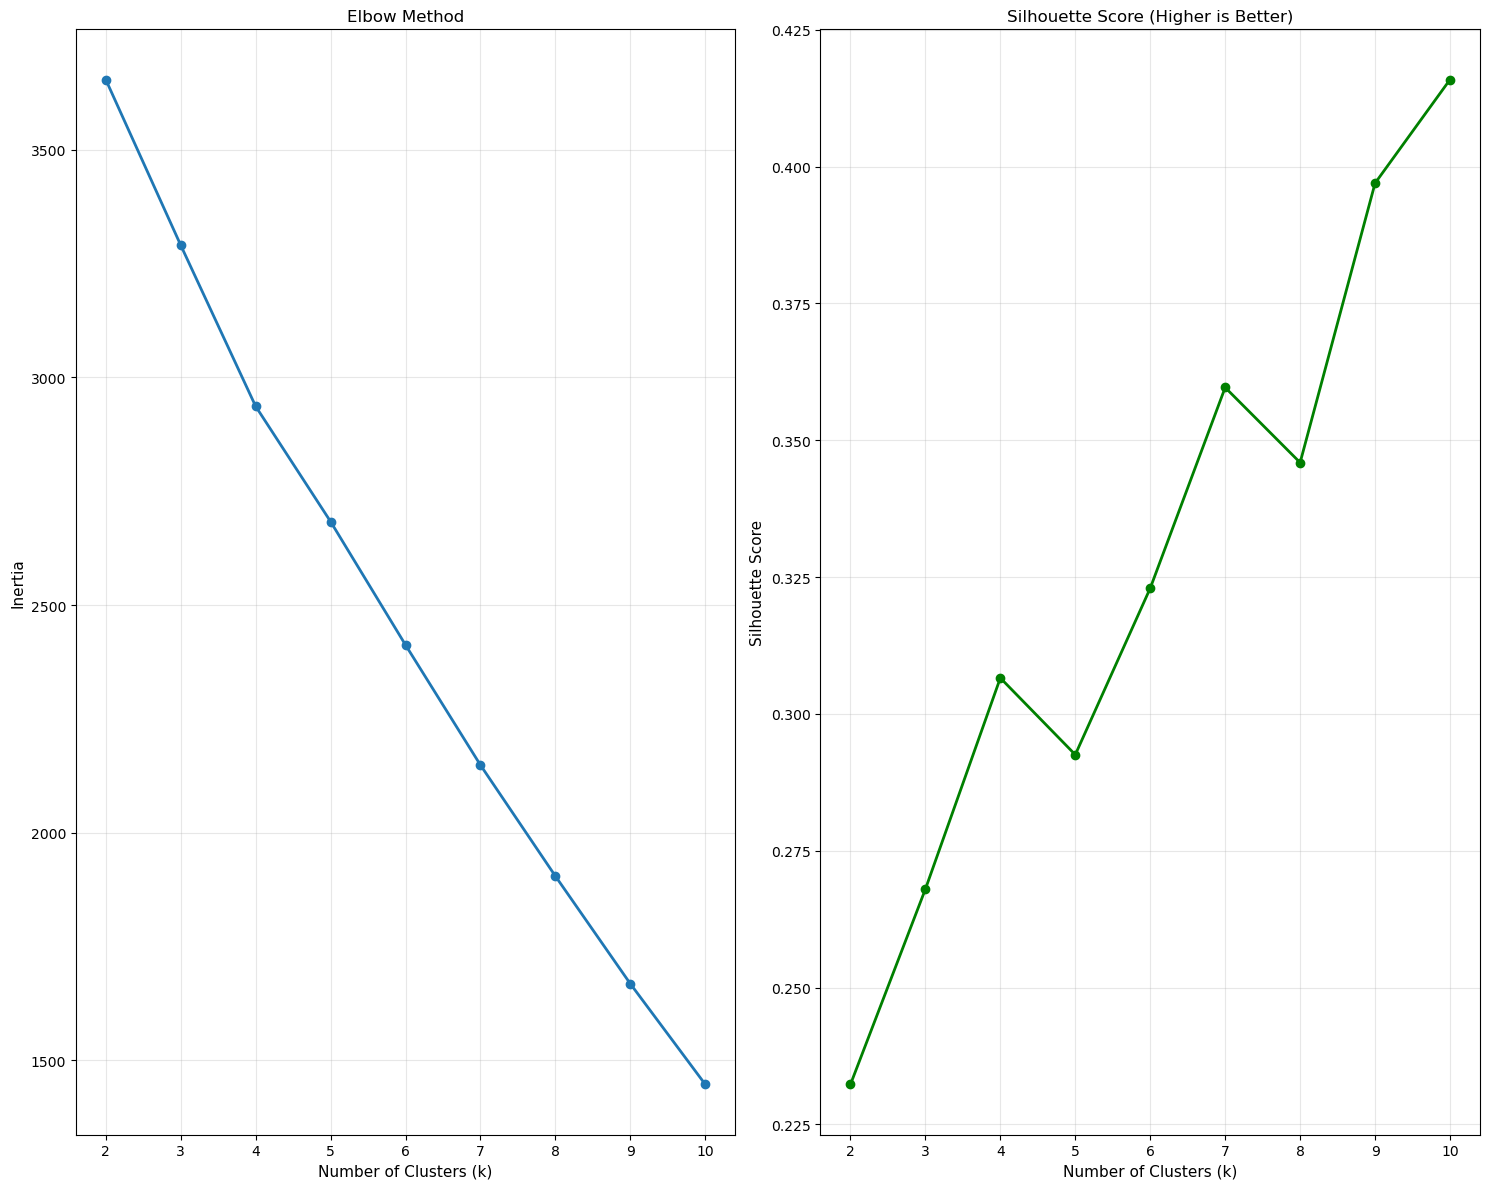


Metrics Summary:
k=2: Silhouette=0.232
k=3: Silhouette=0.268
k=4: Silhouette=0.307
k=5: Silhouette=0.293
k=6: Silhouette=0.323
k=7: Silhouette=0.360
k=8: Silhouette=0.346
k=9: Silhouette=0.397
k=10: Silhouette=0.416


In [200]:
# Test different values of k
k_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, labels))

# Plot evaluation metrics
fig, axes = plt.subplots(1, 2, figsize=(15, 12))

axes[0].plot(k_range, inertias, marker='o', linewidth=2)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[0].set_ylabel('Inertia', fontsize=11)
axes[0].set_title('Elbow Method', fontsize=12)
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, silhouette_scores, marker='o', linewidth=2, color='green')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].set_title('Silhouette Score (Higher is Better)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nMetrics Summary:")
for i, k in enumerate(k_range):
    print(f"k={k}: Silhouette={silhouette_scores[i]:.3f}")

In this case, the **elbow curve** appears **almost linear**, which makes it **difficult** to identify a clear optimal value of k. This suggests that the data may not strongly favor a specific number of clusters. Therefore, we also relied on the **silhouette** method to better evaluate the clustering quality. Based on the silhouette scores, we selected a value of k that provides a good balance between cluster quality and model simplicity , so **optimal_k = 4**

### Step 2: Apply K-Means with Optimal k

In [201]:
# Choose optimal k (you can adjust based on the metrics above)
optimal_k = 4

# Apply K-Means
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_model.fit_predict(X_scaled)

# Add cluster labels to profiles
df_profiles['kmeans_cluster'] = kmeans_labels

print(f"K-Means clustering completed with k={optimal_k}")
print(f"\nCluster distribution:")
print(df_profiles['kmeans_cluster'].value_counts().sort_index())

K-Means clustering completed with k=4

Cluster distribution:
kmeans_cluster
0    127
1     90
2     37
3     17
Name: count, dtype: int64


c:\Users\DELL\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


### Step 3: Visualize K-Means Clusters

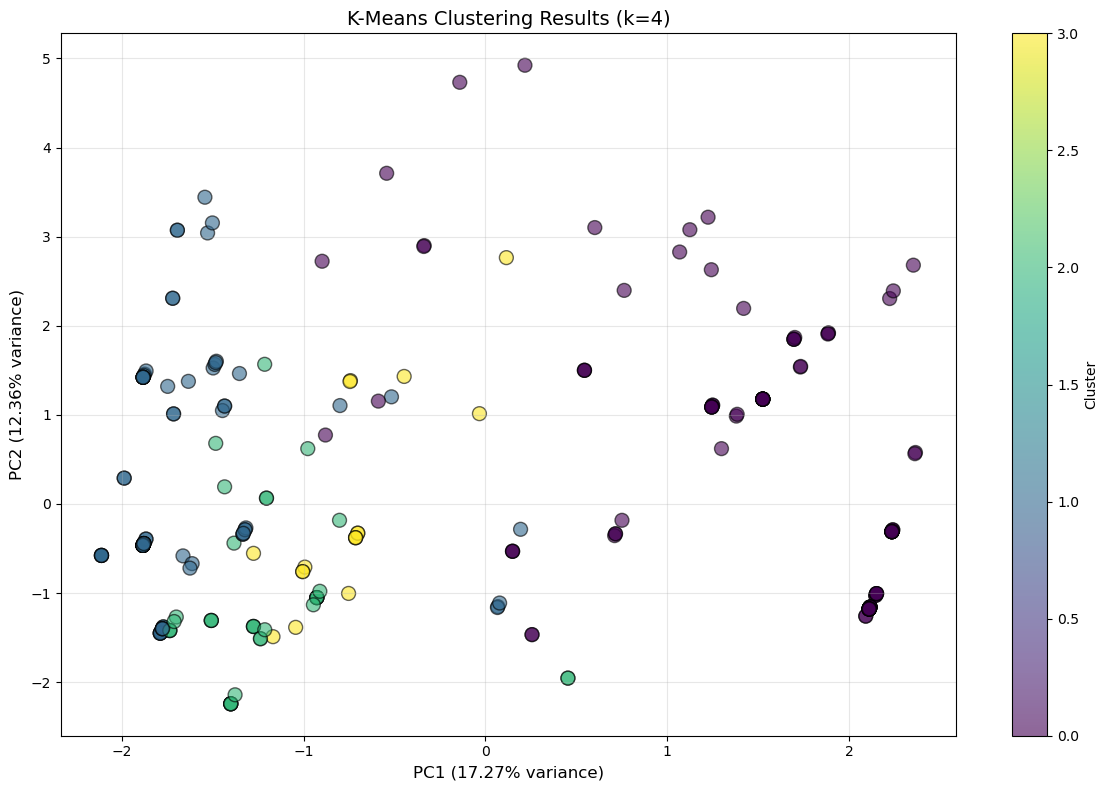

In [202]:
# Visualize K-Means clusters in PCA space
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=kmeans_labels, cmap='viridis', 
                     s=100, alpha=0.6, edgecolors='black')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title(f'K-Means Clustering Results (k={optimal_k})', fontsize=14)
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 4: Analyze K-Means Clusters

In [203]:
# Analyze each cluster
print("="*80)
print("K-MEANS CLUSTER ANALYSIS")
print("="*80)

for cluster_id in range(optimal_k):
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*80}")
    
    cluster_data = df_profiles[df_profiles['kmeans_cluster'] == cluster_id]
    
    print(f"\nSize: {len(cluster_data)} users ({len(cluster_data)/len(df_profiles)*100:.1f}%)")
    
    # Borrower category distribution
    print(f"\nBorrower Category Distribution:")
    print(cluster_data['Catégorie'].value_counts())
    
    # Behavioral stats
    print(f"\nBehavioral Statistics:")
    print(f"  Average books borrowed: {cluster_data['total_borrowed'].mean():.1f}")
    print(f"  Average borrowing duration: {cluster_data['avg_duration'].mean():.1f} days")
    print(f"  Average diversity score: {cluster_data['diversity_score'].mean():.1f}")
    
    # Book category preferences (grouped)
    print(f"\nTop Book Category Preferences:")
    category_cols = [col for col in cluster_data.columns if col.endswith('_pct')]
    avg_preferences = cluster_data[category_cols].mean().sort_values(ascending=False)
    for cat, pct in avg_preferences.head(5).items():
        cat_name = cat.replace('_pct', '')
        print(f"  {cat_name}: {pct:.1f}%")
    
    # Get actual books borrowed by this cluster
    cluster_user_ids = cluster_data['N° lecteur'].tolist()
    cluster_borrowings = df_borrowing[df_borrowing['N° lecteur'].isin(cluster_user_ids)]
    
    print(f"\nCommon Books Borrowed in this Cluster:")
    top_books = cluster_borrowings['book_category'].value_counts().head(5)
    for category, count in top_books.items():
        print(f"  {category}: {count} borrowings")

K-MEANS CLUSTER ANALYSIS

CLUSTER 0

Size: 127 users (46.9%)

Borrower Category Distribution:
Catégorie
1 ére ANNEE    119
Enseignant       8
Name: count, dtype: int64

Behavioral Statistics:
  Average books borrowed: 1.7
  Average borrowing duration: 18.6 days
  Average diversity score: 1.4

Top Book Category Preferences:
  Math_Algebra: 68.4%
  Computer_Science: 14.4%
  Math_General: 10.1%
  Math_Analysis: 3.0%
  Other: 2.6%

Common Books Borrowed in this Cluster:
  Math_Algebra: 136 borrowings
  Computer_Science: 37 borrowings
  Math_General: 27 borrowings
  Math_Analysis: 7 borrowings
  Other: 7 borrowings

CLUSTER 1

Size: 90 users (33.2%)

Borrower Category Distribution:
Catégorie
2 éme ANNEE    90
Name: count, dtype: int64

Behavioral Statistics:
  Average books borrowed: 1.5
  Average borrowing duration: 14.7 days
  Average diversity score: 1.4

Top Book Category Preferences:
  Math_General: 41.9%
  Math_Analysis: 19.8%
  Math_Statistics: 16.1%
  Computer_Science: 12.4%
  Math_

### Step 5: Evaluate K-Means Performance

In [204]:
# Calculate evaluation metrics
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)

print("\nK-MEANS PERFORMANCE METRICS:")
print("="*50)
print(f"Silhouette Score: {kmeans_silhouette:.3f} (higher is better, range: -1 to 1)")


K-MEANS PERFORMANCE METRICS:
Silhouette Score: 0.307 (higher is better, range: -1 to 1)


**=> based on Silhouette : Moderate cluster structure**

### K-Means Conclusion

In [205]:
print("\n" + "="*80)
print("K-MEANS CLUSTERING CONCLUSION")
print("="*80)
print(f"\nK-Means identified {optimal_k} distinct user segments.")
print("\n" + "="*80)


K-MEANS CLUSTERING CONCLUSION

K-Means identified 4 distinct user segments.



---
## Approach 2: DBSCAN Clustering

### Step 1: Find Optimal eps Parameter

* Plot k-distance graph to help determine eps parameter for DBSCAN. The 'elbow' point suggests a good eps value.
* and the MinPts should generally be ≥ the dimensionality of the dataset.

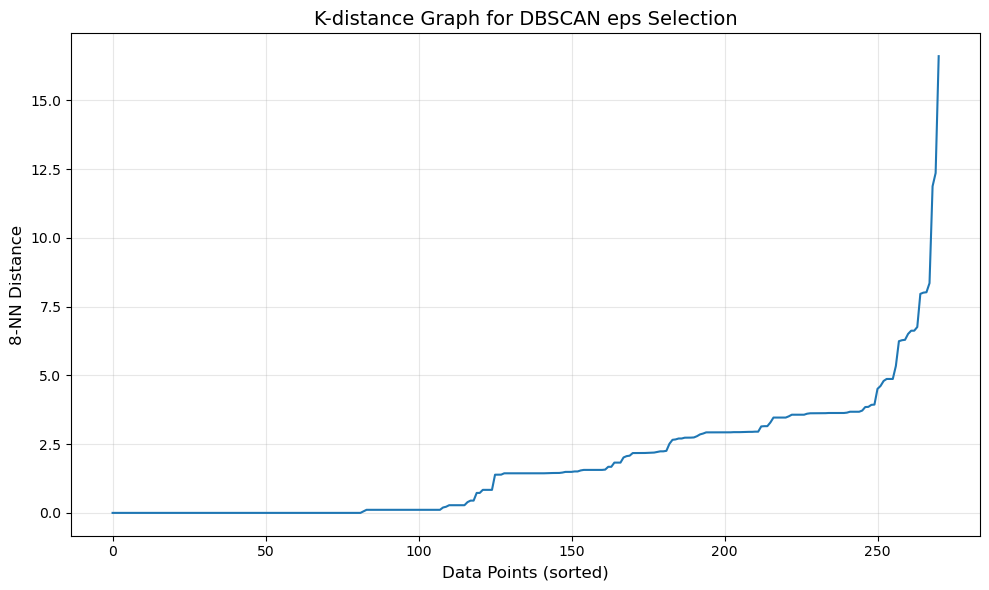

Suggested eps range: 3.68 - 6.24


In [206]:
# Calculate k-distance graph
k = 8 # MinPts parameter ( should be greater then the dim)
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances
distances = np.sort(distances[:, k-1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Data Points (sorted)', fontsize=12)
plt.ylabel(f'{k}-NN Distance', fontsize=12)
plt.title('K-distance Graph for DBSCAN eps Selection', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Suggested eps range: {distances[int(len(distances)*0.9)]:.2f} - {distances[int(len(distances)*0.95)]:.2f}")

### Step 2: Test Different DBSCAN Parameters

In [207]:
# Test different eps values
eps_values = [3.90, 4.5, 5.0, 5.7, 6.2]
min_samples = 8

print("Testing DBSCAN with different eps values:")
print("="*70)

best_eps = None
best_score = -1

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    print(f"\neps={eps}:")
    print(f"  Clusters: {n_clusters}")
    print(f"  Noise points: {n_noise} ({n_noise/len(labels)*100:.1f}%)")
    
    if n_clusters > 1 and n_noise < len(labels) * 0.3:
        # Only calculate silhouette if we have valid clusters
        valid_labels = labels[labels != -1]
        valid_data = X_scaled[labels != -1]
        
        if len(set(valid_labels)) > 1:
            score = silhouette_score(valid_data, valid_labels)
            print(f"  Silhouette Score: {score:.3f}")
            
            if score > best_score:
                best_score = score
                best_eps = eps

print(f"\n{'='*70}")
print(f"Best eps: {best_eps} (Silhouette: {best_score:.3f})")

Testing DBSCAN with different eps values:

eps=3.9:
  Clusters: 2
  Noise points: 17 (6.3%)
  Silhouette Score: 0.349

eps=4.5:
  Clusters: 2
  Noise points: 15 (5.5%)
  Silhouette Score: 0.343

eps=5.0:
  Clusters: 1
  Noise points: 15 (5.5%)

eps=5.7:
  Clusters: 1
  Noise points: 11 (4.1%)

eps=6.2:
  Clusters: 1
  Noise points: 10 (3.7%)

Best eps: 3.9 (Silhouette: 0.349)


### Step 3: Apply DBSCAN with Optimal Parameters

In [208]:
# Apply DBSCAN with best parameters
optimal_eps = best_eps if best_eps is not None else 2.5

dbscan_model = DBSCAN(eps=optimal_eps, min_samples=min_samples)
dbscan_labels = dbscan_model.fit_predict(X_scaled)

# Add cluster labels to profiles
df_profiles['dbscan_cluster'] = dbscan_labels

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_dbscan = list(dbscan_labels).count(-1)

print(f"DBSCAN clustering completed")
print(f"Parameters: eps={optimal_eps}, min_samples={min_samples}")
print(f"\nResults:")
print(f"  Number of clusters: {n_clusters_dbscan}")
print(f"  Noise points: {n_noise_dbscan} ({n_noise_dbscan/len(dbscan_labels)*100:.1f}%)")
print(f"\nCluster distribution:")
print(df_profiles['dbscan_cluster'].value_counts().sort_index())

DBSCAN clustering completed
Parameters: eps=3.9, min_samples=8

Results:
  Number of clusters: 2
  Noise points: 17 (6.3%)

Cluster distribution:
dbscan_cluster
-1     17
 0    242
 1     12
Name: count, dtype: int64


### Step 4: Visualize DBSCAN Clusters

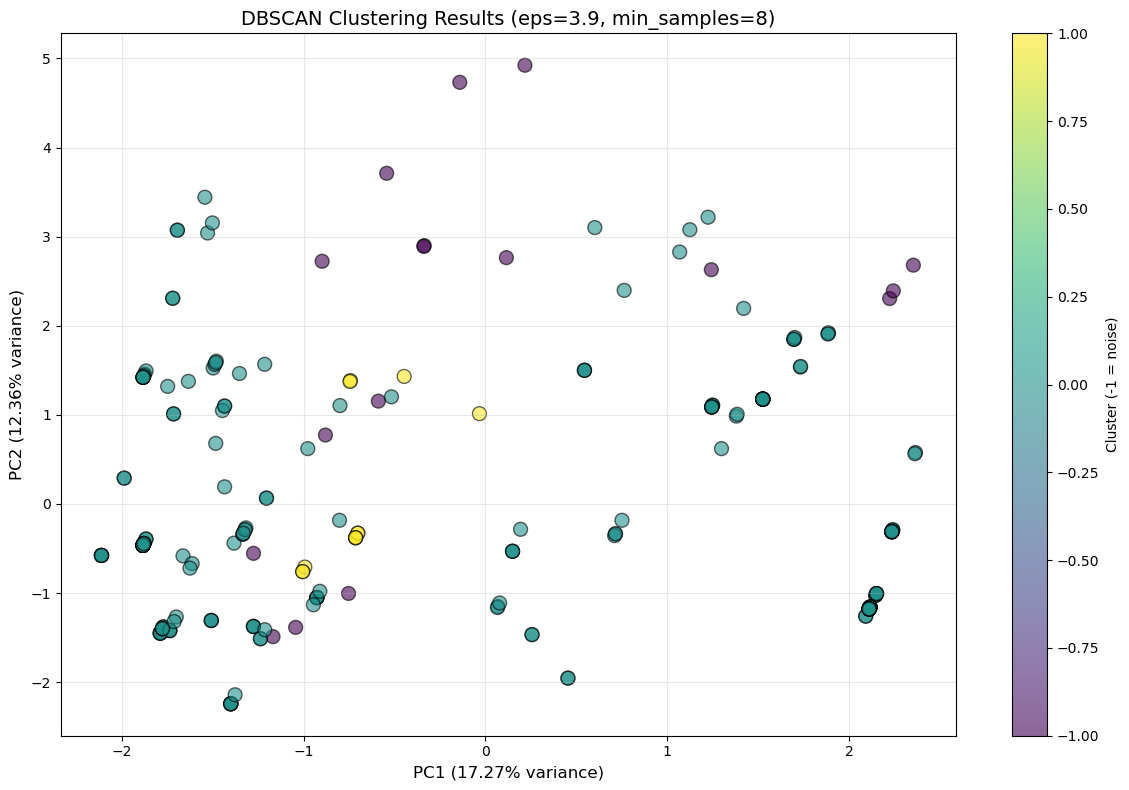

In [209]:
# Visualize DBSCAN clusters in PCA space
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=dbscan_labels, cmap='viridis', 
                     s=100, alpha=0.6, edgecolors='black')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title(f'DBSCAN Clustering Results (eps={optimal_eps}, min_samples={min_samples})', fontsize=14)
plt.colorbar(scatter, label='Cluster (-1 = noise)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 5: Analyze DBSCAN Clusters

In [210]:
# Analyze each DBSCAN cluster
print("="*80)
print("DBSCAN CLUSTER ANALYSIS")
print("="*80)

unique_clusters = sorted([c for c in df_profiles['dbscan_cluster'].unique() if c != -1])

for cluster_id in unique_clusters:
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*80}")
    
    cluster_data = df_profiles[df_profiles['dbscan_cluster'] == cluster_id]
    
    print(f"\nSize: {len(cluster_data)} users ({len(cluster_data)/len(df_profiles)*100:.1f}%)")
    
    # Borrower category distribution
    print(f"\nBorrower Category Distribution:")
    print(cluster_data['Catégorie'].value_counts())
    
    # Behavioral stats
    print(f"\nBehavioral Statistics:")
    print(f"  Average books borrowed: {cluster_data['total_borrowed'].mean():.1f}")
    print(f"  Average borrowing duration: {cluster_data['avg_duration'].mean():.1f} days")
    print(f"  Average diversity score: {cluster_data['diversity_score'].mean():.1f}")
    
    # Book category preferences
    print(f"\nTop Book Category Preferences:")
    category_cols = [col for col in cluster_data.columns if col.endswith('_pct')]
    avg_preferences = cluster_data[category_cols].mean().sort_values(ascending=False)
    for cat, pct in avg_preferences.head(5).items():
        cat_name = cat.replace('_pct', '')
        print(f"  {cat_name}: {pct:.1f}%")
    
    # Get actual books borrowed
    cluster_user_ids = cluster_data['N° lecteur'].tolist()
    cluster_borrowings = df_borrowing[df_borrowing['N° lecteur'].isin(cluster_user_ids)]
    
    print(f"\nCommon Books Borrowed in this Cluster:")
    top_books = cluster_borrowings['book_category'].value_counts().head(5)
    for category, count in top_books.items():
        print(f"  {category}: {count} borrowings")

# Analyze noise points
if n_noise_dbscan > 0:
    print(f"\n{'='*80}")
    print(f"NOISE POINTS (Cluster -1)")
    print(f"{'='*80}")
    
    noise_data = df_profiles[df_profiles['dbscan_cluster'] == -1]
    print(f"\nSize: {len(noise_data)} users ({len(noise_data)/len(df_profiles)*100:.1f}%)")
    print(f"\nThese are outlier users with unique borrowing patterns.")

DBSCAN CLUSTER ANALYSIS

CLUSTER 0

Size: 242 users (89.3%)

Borrower Category Distribution:
Catégorie
1 ére ANNEE    115
2 éme ANNEE     90
3 ème ANNEE     37
Name: count, dtype: int64

Behavioral Statistics:
  Average books borrowed: 1.5
  Average borrowing duration: 14.8 days
  Average diversity score: 1.4

Top Book Category Preferences:
  Math_Algebra: 37.9%
  Math_General: 22.0%
  Computer_Science: 14.0%
  Math_Analysis: 13.3%
  Math_Statistics: 8.7%

Common Books Borrowed in this Cluster:
  Math_Algebra: 140 borrowings
  Math_General: 80 borrowings
  Computer_Science: 55 borrowings
  Math_Analysis: 46 borrowings
  Math_Statistics: 35 borrowings

CLUSTER 1

Size: 12 users (4.4%)

Borrower Category Distribution:
Catégorie
4 éme ANNEE    12
Name: count, dtype: int64

Behavioral Statistics:
  Average books borrowed: 1.4
  Average borrowing duration: 12.4 days
  Average diversity score: 1.2

Top Book Category Preferences:
  Computer_Science: 58.3%
  Other: 37.5%
  Math_Algebra: 4.2%
 

### Step 6: Evaluate DBSCAN Performance

In [211]:
# Calculate evaluation metrics (excluding noise)
if n_clusters_dbscan > 1:
    valid_labels = dbscan_labels[dbscan_labels != -1]
    valid_data = X_scaled[dbscan_labels != -1]
    
    if len(set(valid_labels)) > 1:
        dbscan_silhouette = silhouette_score(valid_data, valid_labels)
        dbscan_davies_bouldin = davies_bouldin_score(valid_data, valid_labels)
        dbscan_calinski = calinski_harabasz_score(valid_data, valid_labels)
        
        print("\nDBSCAN PERFORMANCE METRICS (excluding noise):")
        print("="*50)
        print(f"Silhouette Score: {dbscan_silhouette:.3f} (higher is better)")
        print(f"Davies-Bouldin Score: {dbscan_davies_bouldin:.3f} (lower is better)")
        print(f"Calinski-Harabasz Score: {dbscan_calinski:.1f} (higher is better)")
else:
    print("\nInsufficient clusters for metric calculation")


DBSCAN PERFORMANCE METRICS (excluding noise):
Silhouette Score: 0.349 (higher is better)
Davies-Bouldin Score: 1.126 (lower is better)
Calinski-Harabasz Score: 28.2 (higher is better)


### DBSCAN Conclusion

In [212]:
print("\n" + "="*80)
print("DBSCAN CLUSTERING CONCLUSION")
print("="*80)
print(f"\nDBSCAN identified {n_clusters_dbscan} dense clusters and {n_noise_dbscan} outlier users.")
print(f"\nStrengths:")
print("- Discovers clusters of arbitrary shape")
print("- Identifies outliers/noise points automatically")
print("- No need to specify number of clusters beforehand")
print(f"\nLimitations:")
print("- Sensitive to eps and min_samples parameters")
print("- Struggles with varying density clusters")
print("- May classify many points as noise in sparse data")
print("\n" + "="*80)


DBSCAN CLUSTERING CONCLUSION

DBSCAN identified 2 dense clusters and 17 outlier users.

Strengths:
- Discovers clusters of arbitrary shape
- Identifies outliers/noise points automatically
- No need to specify number of clusters beforehand

Limitations:
- Sensitive to eps and min_samples parameters
- Struggles with varying density clusters
- May classify many points as noise in sparse data



---
## Approach 3: Hierarchical Clustering

### Step 1: Create Dendrogram

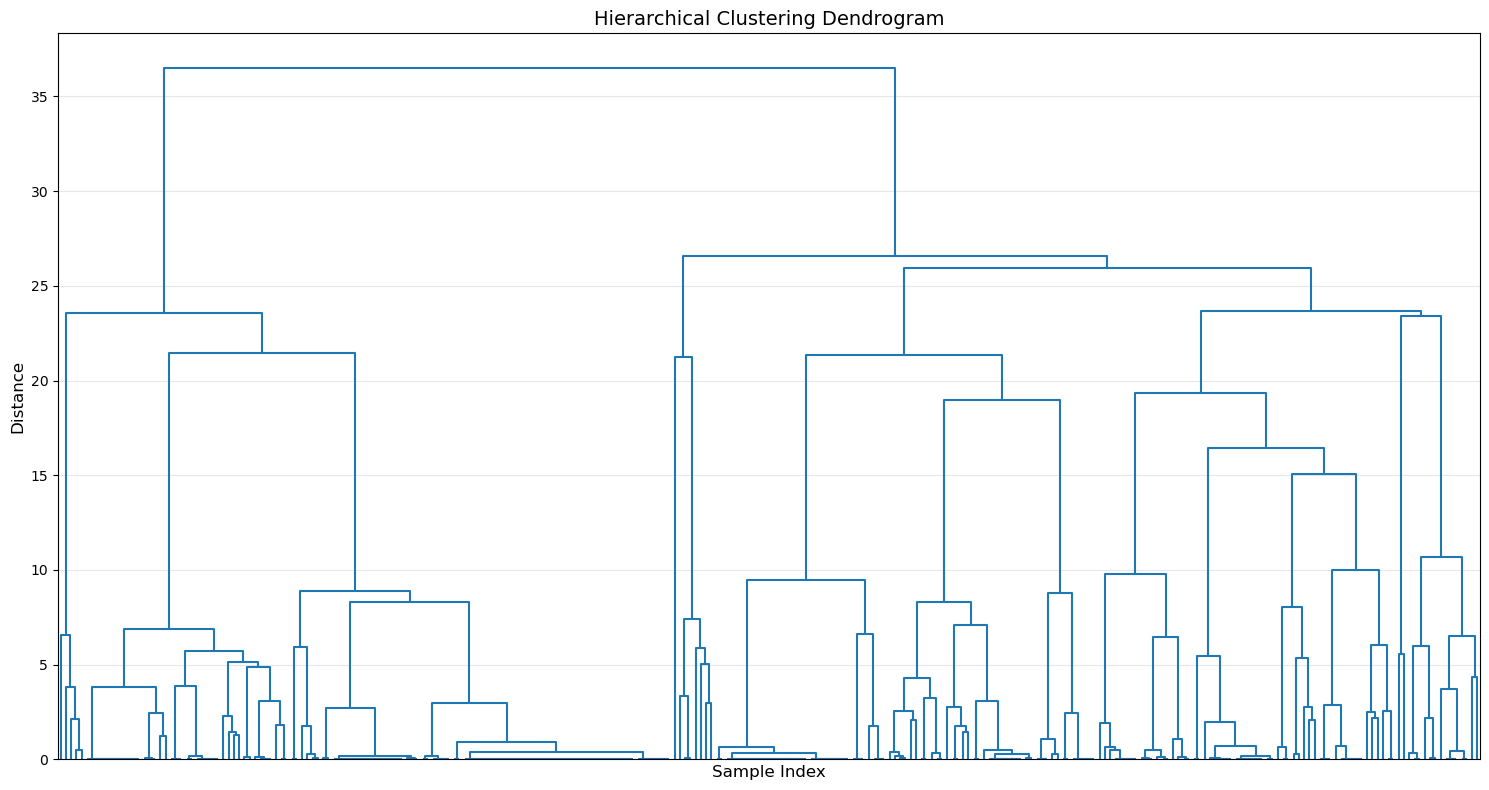

Dendrogram created using Ward linkage method


In [213]:
# Create linkage matrix
linkage_matrix = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, no_labels=True, color_threshold=0)
plt.title('Hierarchical Clustering Dendrogram', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Dendrogram created using Ward linkage method")

### Step 2: Determine Optimal Number of Clusters

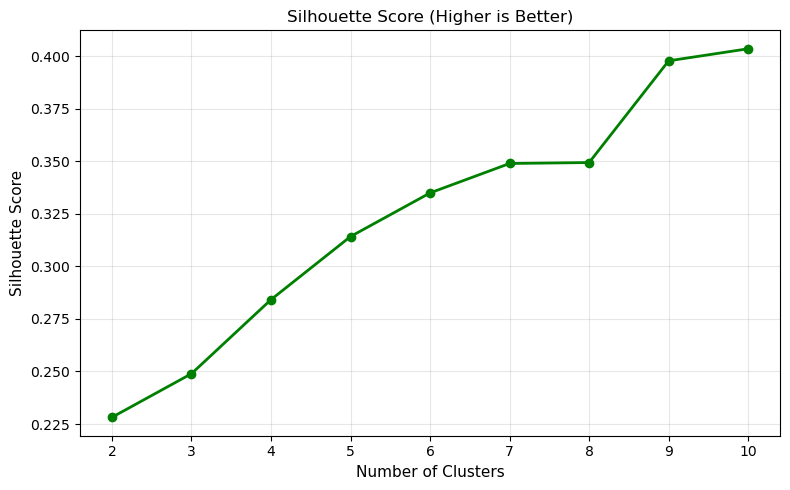


Metrics Summary:
n=2: Silhouette=0.228
n=3: Silhouette=0.249
n=4: Silhouette=0.284
n=5: Silhouette=0.314
n=6: Silhouette=0.335
n=7: Silhouette=0.349
n=8: Silhouette=0.349
n=9: Silhouette=0.398
n=10: Silhouette=0.404


In [214]:
# Test different numbers of clusters
n_clusters_range = range(2, 11)
hierarchical_silhouettes = []

for n in n_clusters_range:
    hierarchical = AgglomerativeClustering(n_clusters=n, linkage='ward')
    labels = hierarchical.fit_predict(X_scaled)
    
    hierarchical_silhouettes.append(silhouette_score(X_scaled, labels))

# Plot metrics
fig, ax = plt.subplots(1, 1, figsize=(8, 5))  # Just one plot

ax.plot(n_clusters_range, hierarchical_silhouettes, marker='o', linewidth=2, color='green')
ax.set_xlabel('Number of Clusters', fontsize=11)
ax.set_ylabel('Silhouette Score', fontsize=11)
ax.set_title('Silhouette Score (Higher is Better)', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nMetrics Summary:")
for i, n in enumerate(n_clusters_range):
    print(f"n={n}: Silhouette={hierarchical_silhouettes[i]:.3f}")

### Step 3: Apply Hierarchical Clustering with Optimal n

In [215]:
# Choose optimal number of clusters
optimal_n_hierarchical = 6
# Apply Hierarchical Clustering
hierarchical_model = AgglomerativeClustering(n_clusters=optimal_n_hierarchical, linkage='ward')
hierarchical_labels = hierarchical_model.fit_predict(X_scaled)

# Add cluster labels to profiles
df_profiles['hierarchical_cluster'] = hierarchical_labels

print(f"Hierarchical clustering completed with n_clusters={optimal_n_hierarchical}")
print(f"\nCluster distribution:")
print(df_profiles['hierarchical_cluster'].value_counts().sort_index())

Hierarchical clustering completed with n_clusters=6

Cluster distribution:
hierarchical_cluster
0     16
1    112
2      8
3     73
4     57
5      5
Name: count, dtype: int64


### Step 4: Visualize Hierarchical Clusters

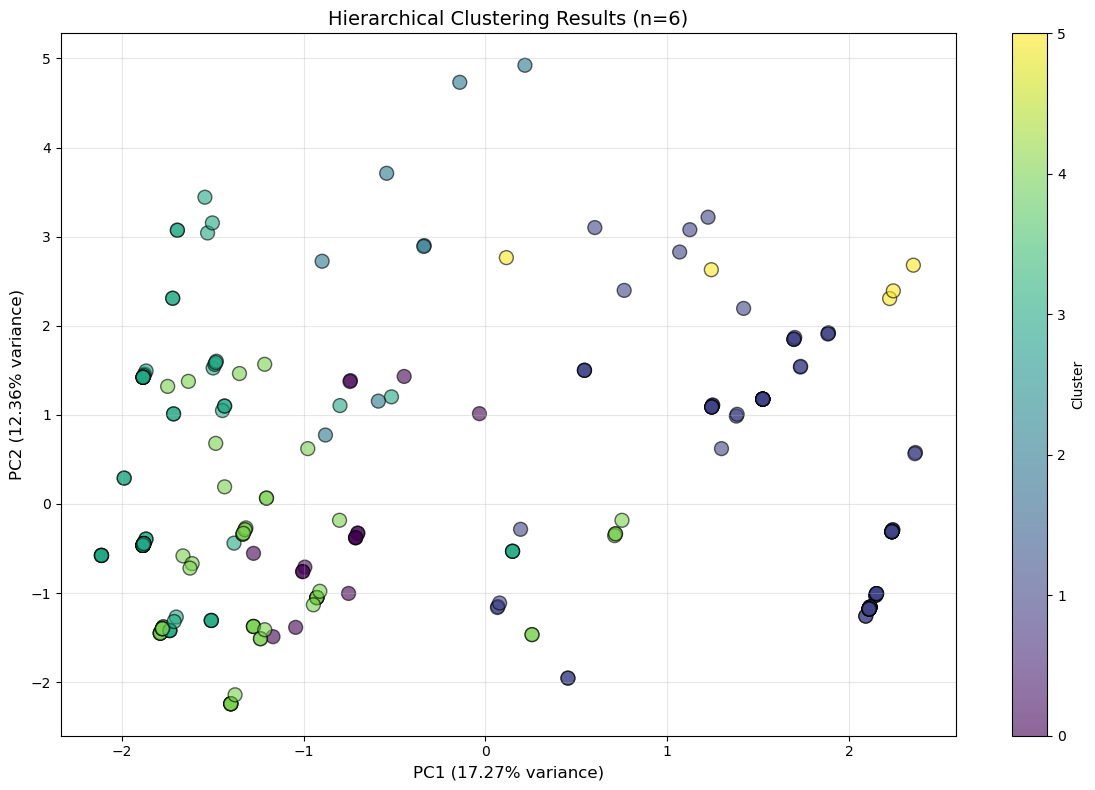

In [216]:
# Visualize Hierarchical clusters in PCA space
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=hierarchical_labels, cmap='viridis', 
                     s=100, alpha=0.6, edgecolors='black')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title(f'Hierarchical Clustering Results (n={optimal_n_hierarchical})', fontsize=14)
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 5: Analyze Hierarchical Clusters

In [217]:
# Analyze each hierarchical cluster
print("="*80)
print("HIERARCHICAL CLUSTER ANALYSIS")
print("="*80)

for cluster_id in range(optimal_n_hierarchical):
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*80}")
    
    cluster_data = df_profiles[df_profiles['hierarchical_cluster'] == cluster_id]
    
    print(f"\nSize: {len(cluster_data)} users ({len(cluster_data)/len(df_profiles)*100:.1f}%)")
    
    # Borrower category distribution
    print(f"\nBorrower Category Distribution:")
    print(cluster_data['Catégorie'].value_counts())
    
    # Behavioral stats
    print(f"\nBehavioral Statistics:")
    print(f"  Average books borrowed: {cluster_data['total_borrowed'].mean():.1f}")
    print(f"  Average borrowing duration: {cluster_data['avg_duration'].mean():.1f} days")
    print(f"  Average diversity score: {cluster_data['diversity_score'].mean():.1f}")
    
    # Book category preferences
    print(f"\nTop Book Category Preferences:")
    category_cols = [col for col in cluster_data.columns if col.endswith('_pct')]
    avg_preferences = cluster_data[category_cols].mean().sort_values(ascending=False)
    for cat, pct in avg_preferences.head(5).items():
        cat_name = cat.replace('_pct', '')
        print(f"  {cat_name}: {pct:.1f}%")
    
    # Get actual books borrowed
    cluster_user_ids = cluster_data['N° lecteur'].tolist()
    cluster_borrowings = df_borrowing[df_borrowing['N° lecteur'].isin(cluster_user_ids)]
    
    print(f"\nCommon Books Borrowed in this Cluster:")
    top_books = cluster_borrowings['book_category'].value_counts().head(5)
    for category, count in top_books.items():
        print(f"  {category}: {count} borrowings")

HIERARCHICAL CLUSTER ANALYSIS

CLUSTER 0

Size: 16 users (5.9%)

Borrower Category Distribution:
Catégorie
4 éme ANNEE    14
Employé         2
Name: count, dtype: int64

Behavioral Statistics:
  Average books borrowed: 1.3
  Average borrowing duration: 12.4 days
  Average diversity score: 1.2

Top Book Category Preferences:
  Computer_Science: 50.0%
  Other: 34.4%
  Math_Analysis: 6.2%
  Math_General: 6.2%
  Math_Algebra: 3.1%

Common Books Borrowed in this Cluster:
  Computer_Science: 11 borrowings
  Other: 7 borrowings
  Math_Analysis: 1 borrowings
  Math_Algebra: 1 borrowings
  Math_General: 1 borrowings

CLUSTER 1

Size: 112 users (41.3%)

Borrower Category Distribution:
Catégorie
1 ére ANNEE    106
2 éme ANNEE      4
3 ème ANNEE      2
Name: count, dtype: int64

Behavioral Statistics:
  Average books borrowed: 1.7
  Average borrowing duration: 15.8 days
  Average diversity score: 1.4

Top Book Category Preferences:
  Math_Algebra: 81.1%
  Computer_Science: 8.9%
  Math_General: 7.1

### Step 6: Evaluate Hierarchical Performance

In [218]:
# Calculate evaluation metrics
hierarchical_silhouette = silhouette_score(X_scaled, hierarchical_labels)

print("\nHIERARCHICAL CLUSTERING PERFORMANCE METRICS:")
print("="*50)
print(f"Silhouette Score: {hierarchical_silhouette:.3f} (higher is better)")


HIERARCHICAL CLUSTERING PERFORMANCE METRICS:
Silhouette Score: 0.335 (higher is better)


### Hierarchical Clustering Conclusion

In [219]:
print("\n" + "="*80)
print("HIERARCHICAL CLUSTERING CONCLUSION")
print("="*80)
print(f"\nHierarchical clustering identified {optimal_n_hierarchical} nested user segments.")
print("\n" + "="*80)


HIERARCHICAL CLUSTERING CONCLUSION

Hierarchical clustering identified 6 nested user segments.



---
## Final Comparison of All Clustering Approaches

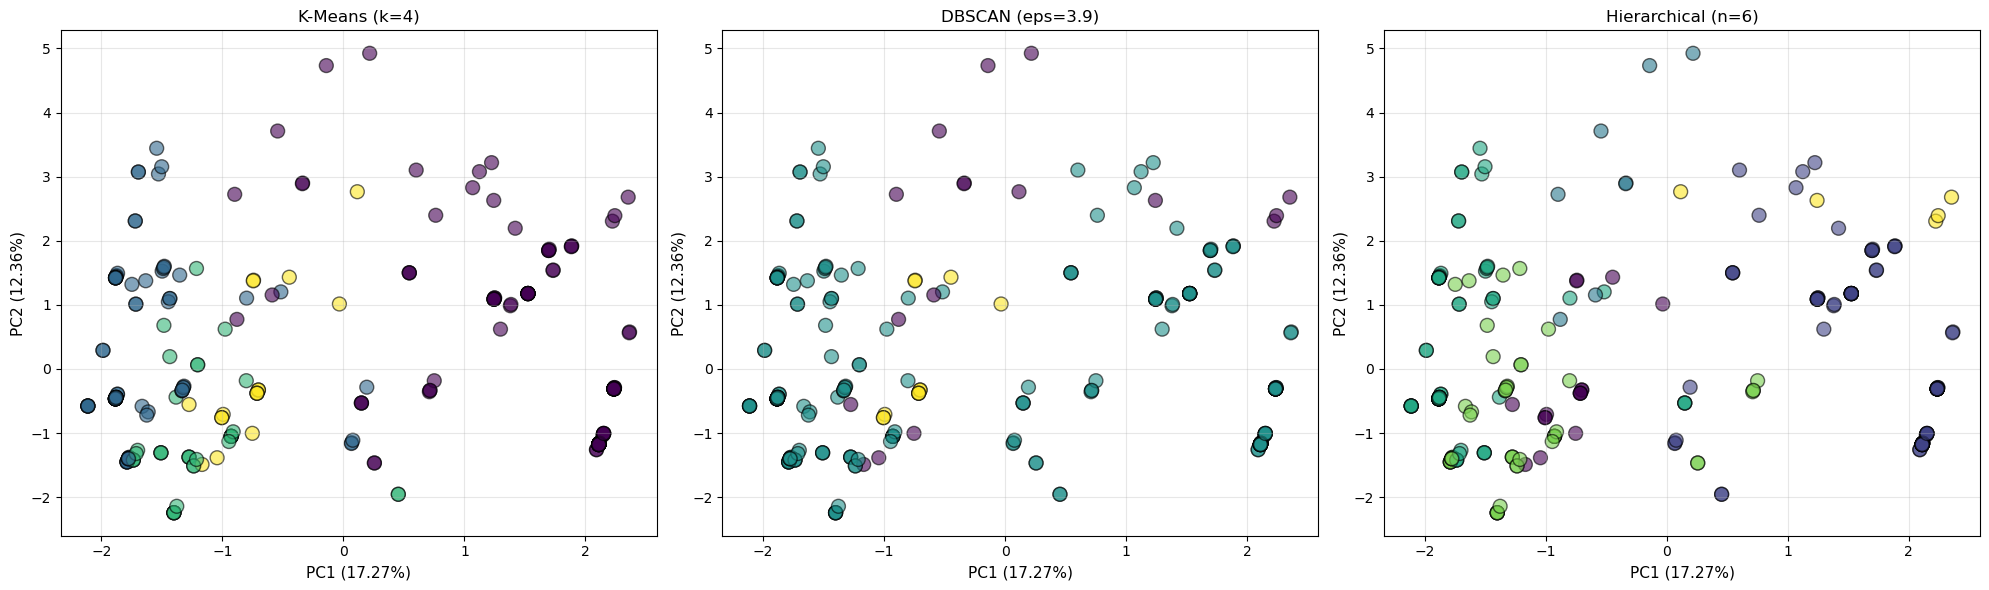

In [220]:
# Create comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# K-Means
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, 
                cmap='viridis', s=100, alpha=0.6, edgecolors='black')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=11)
axes[0].set_title(f'K-Means (k={optimal_k})', fontsize=12)
axes[0].grid(True, alpha=0.3)

# DBSCAN
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, 
                cmap='viridis', s=100, alpha=0.6, edgecolors='black')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=11)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=11)
axes[1].set_title(f'DBSCAN (eps={optimal_eps})', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Hierarchical
axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, 
                cmap='viridis', s=100, alpha=0.6, edgecolors='black')
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})', fontsize=11)
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})', fontsize=11)
axes[2].set_title(f'Hierarchical (n={optimal_n_hierarchical})', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [221]:
# Performance comparison table
comparison_data = {
    'Algorithm': ['K-Means', 'DBSCAN', 'Hierarchical'],
    'N_Clusters': [optimal_k, n_clusters_dbscan, optimal_n_hierarchical],
    'Silhouette': [kmeans_silhouette, 
                   dbscan_silhouette if n_clusters_dbscan > 1 else 'N/A', 
                   hierarchical_silhouette],
}

df_comparison = pd.DataFrame(comparison_data)
print("\n" + "="*50)
print("CLUSTERING ALGORITHMS PERFORMANCE COMPARISON")
print("="*50)
print(df_comparison.to_string(index=False))
print("\n" + "="*50)


CLUSTERING ALGORITHMS PERFORMANCE COMPARISON
   Algorithm  N_Clusters  Silhouette
     K-Means           4    0.306566
      DBSCAN           2    0.348891
Hierarchical           6    0.334969



## Save Results

In [222]:
# Save user profiles with all cluster assignments
df_profiles.to_csv('../data/clustering_result/user_profiles_clustered.csv', index=False)
# Save borrowing data with categories
df_borrowing.to_csv('../data/clustering_result/borrowing_with_categories.csv', index=False)

## Summary and Insights

In [223]:
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

print(f"\n1. DATA OVERVIEW:")
print(f"   - Total borrowers: {df_profiles.shape[0]}")
print(f"   - Total borrowings: {len(df_borrowing)}")
print(f"   - Grouped book categories: {len(df_borrowing['book_category'].unique())}")

print(f"\n2. CLUSTERING RESULTS:")
print(f"   - K-Means: {optimal_k} clusters")
print(f"   - DBSCAN: {n_clusters_dbscan} clusters + {n_noise_dbscan} noise points")
print(f"   - Hierarchical: {optimal_n_hierarchical} clusters")



FINAL SUMMARY

1. DATA OVERVIEW:
   - Total borrowers: 271
   - Total borrowings: 422
   - Grouped book categories: 7

2. CLUSTERING RESULTS:
   - K-Means: 4 clusters
   - DBSCAN: 2 clusters + 17 noise points
   - Hierarchical: 6 clusters
